In [ ]:
%pip install --quiet --upgrade langchain langchain-community langchain-openai

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 37.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.9/62.9 kB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.4/44.4 kB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.9/50.9 kB 2.6 MB/s eta 0:00:00


In [ ]:
%pip install faiss-cpu

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 31.3/31.3 MB 59.2 MB/s eta 0:00:00


## Embed the names

In [ ]:
from langchain_community.vectorstores import FAISS
from langchain_openai import ChatOpenAI, OpenAIEmbeddings
import pandas as pd
from google.colab import userdata
import numpy as np

In [ ]:
api_key = userdata.get('OPEN_API_KEY') #pass API key here

In [ ]:
names_df = pd.read_csv("/content/drive/MyDrive/Colab datasets/natioanlity_diaspora_check.csv")

In [ ]:
names_df.shape

(7703, 9)

**Check sample data containing names & nationality of 7k humans**

In [ ]:
names_df[['EMP_NAME','NATIONALITY']].head()

,EMP_NAME,NATIONALITY
0,Javed Khan Katib Gul,Afghanistan
1,Gul Sharif Wali Mohd,Afghanistan
2,Ahmed Shah Momtaz Shah Momtaz,Afghanistan
3,Fatima Zohra Bousmaha,Algeria
4,Yousuf Masoud Zahri,Algeria


Enable starified sampling as many nationalities are dominating

In [ ]:
def stratified_sampling(df, strata_col, sample_size):
    groups = df.groupby(strata_col)
    sample = pd.DataFrame()

    for _, group in groups:
        stratum_sample = group.sample(frac=sample_size, replace=False, random_state=7)
        sample = pd.concat([sample,stratum_sample],ignore_index=True)

    return sample

Embed the names using OpenAI Text Embeddings Small model

In [ ]:
text_embeddings_list = list(names_df.EMP_NAME.values)
faiss_embeddings = FAISS.from_texts(texts = text_embeddings_list,
                      embedding=OpenAIEmbeddings(model="text-embedding-3-small",api_key=api_key),
                      ids=list(names_df.index.values))
#save the embeddings to local for future re-use
faiss_embeddings.save_local('/content/drive/MyDrive/Colab datasets','emp_names_faiss')

Load the embeddings if required

In [ ]:
faiss_embeddings = FAISS.load_local(folder_path='/content/drive/MyDrive/Colab datasets/',embeddings=OpenAIEmbeddings(model="text-embedding-3-small",api_key=api_key),
                                    allow_dangerous_deserialization=True,index_name='emp_names_faiss')

In [ ]:
names_embeddings = faiss_embeddings.index.reconstruct_n()

In [ ]:
len(names_embeddings) #check the total count of embeddings

7703

Example of how one embedding looks like - one name

In [ ]:
names_embeddings[0]   #1536 dimensions

array([-0.0249825 , -0.03775765,  0.04059657, ..., -0.01635928,
        0.01132611, -0.00842805], dtype=float32)

## Dimensionality reduction

In [ ]:
# Reduce dimensionality using PCA
from sklearn.decomposition import PCA

# Function to return the principal components
def get_pc(arr,n):
  pca = PCA(n_components=n)
  embeds_transform = pca.fit_transform(arr)
  return embeds_transform,pca

In [ ]:
# Reduce embeddings to 20 principal components to aid visualization
embeds = np.array(names_embeddings)
embeds_pc,pca_ = get_pc(embeds,20)

In [ ]:
embeds_pc[:2] #first 2 names and their 20 PCA components

array([[-0.09300845,  0.18013537, -0.06791539,  0.19947031,  0.2678019 ,
        -0.00209294,  0.10870867,  0.05434865,  0.03078735, -0.05413409,
         0.00351935, -0.09187871, -0.15307523, -0.08164664,  0.17120326,
        -0.06594829,  0.01905754,  0.0227912 , -0.00348109,  0.07069976],
       [-0.15792781,  0.15111397, -0.09308033,  0.2854962 ,  0.20149429,
         0.00660513, -0.01900492, -0.07885266,  0.03293109,  0.01312181,
         0.02352976, -0.0555312 , -0.03355673, -0.0062109 ,  0.05776484,
         0.05576078, -0.11360165,  0.05909261, -0.04801221, -0.06847032]],
      dtype=float32)

Check for total variance explained by PC components

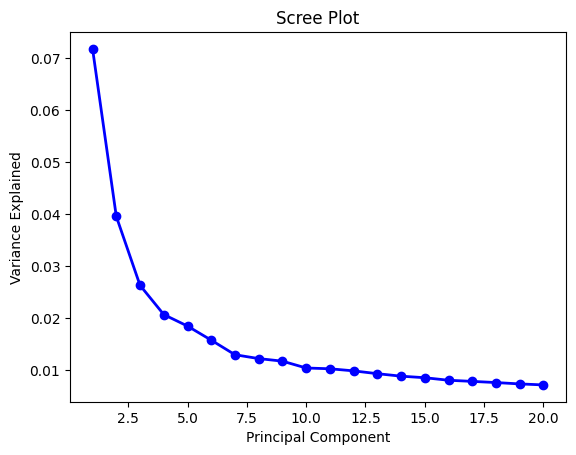

In [ ]:
import matplotlib.pyplot as plt

PC_values = np.arange(pca_.n_components) + 1
plt.plot(PC_values, pca_.explained_variance_ratio_, 'o-', linewidth=2, color='blue')
plt.title('Scree Plot')
plt.xlabel('Principal Component')
plt.ylabel('Variance Explained')
plt.show()

In [ ]:
pca_.explained_variance_ratio_.sum() # total variance explained by 20 components

0.32449466

### Visualization of reduced embeddings for few names

In [ ]:

import altair as alt

# Reshape the data for visualization purposes
source = pd.DataFrame(embeds_pc[:10])
source = pd.concat([source,pd.Series(text_embeddings_list[:10],name='query')], axis=1)
source = source.melt(id_vars=['query'])

# Configure the plot
chart = alt.Chart(source).mark_rect().encode(
    x=alt.X('variable:N', title="Embedding"),
    y=alt.Y('query:N', title='',axis=alt.Axis(labelLimit=500)),
    color=alt.Color('value:Q', title="Value", scale=alt.Scale(
                range=["#917EF3", "#000000"]))
)

result = chart.configure(background='#ffffff'
        ).properties(
        width=700,
        height=400,
        title='Embeddings with 20 dimensions'
       ).configure_axis(
      labelFontSize=15,
      titleFontSize=12)

# Show the plot
result

/usr/local/lib/python3.10/dist-packages/altair/utils/core.py:384: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  col = df[col_name].apply(to_list_if_array, convert_dtype=False)
/usr/local/lib/python3.10/dist-packages/altair/utils/core.py:384: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  col = df[col_name].apply(to_list_if_array, convert_dtype=False)


alt.Chart(...)

**Its clearly seen from above image that few names like row#2 and row#4, shows very similiar embedding values**

In [ ]:
# Function to generate the 2D plot
def generate_chart(df,xcol,ycol,lbl='on',color='basic',title=''):
  chart = alt.Chart(df).mark_circle(size=500).encode(
    x=
    alt.X(xcol,
        scale=alt.Scale(zero=False),
        axis=alt.Axis(labels=False, ticks=False, domain=False)
    ),

    y=
    alt.Y(ycol,
        scale=alt.Scale(zero=False),
        axis=alt.Axis(labels=False, ticks=False, domain=False)
    ),

    color= alt.value('#333293') if color == 'basic' else color,
    tooltip=['query']
    )

  if lbl == 'on':
    text = chart.mark_text(align='left', baseline='middle',dx=15, size=13,color='black').encode(text='query', color= alt.value('black'))
  else:
    text = chart.mark_text(align='left', baseline='middle',dx=10).encode()

  result = (chart + text).configure(background="#FDF7F0"
        ).properties(
        width=800,
        height=500,
        title=title
       ).configure_legend(
  orient='bottom', titleFontSize=18,labelFontSize=18)

  return result

In [ ]:
# Reduce embeddings to 2 principal components to aid visualization
embeds_pc2 = get_pc(embeds,2)

# Add the principal components to dataframe
df_pc2 = pd.concat([pd.Series(text_embeddings_list,name='query'), pd.DataFrame(embeds_pc),names_df.NATIONALITY.reset_index()], axis=1)
df_pc2 = df_pc2.loc[:50]
# Plot the 2D embeddings on a chart
df_pc2.columns = df_pc2.columns.astype(str)
generate_chart(df_pc2,'0','1',color = 'NATIONALITY',title='2D Embeddings')

alt.LayerChart(...)

***Its clearly seen that Clusters of some nationalities are tighly packed (like Bangladesh), gives us confidence that our approach is working fine***

## Classification using ML

In [ ]:
import numpy as np
from ast import literal_eval

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split,StratifiedKFold
from sklearn.metrics import classification_report, accuracy_score,f1_score,log_loss

### Discard Nationalities with < 10 counts in DF

In [ ]:
low_counts_nationality = names_df.NATIONALITY.value_counts()<25
low_counts_nationality = low_counts_nationality.reset_index()

discarded_nationality = low_counts_nationality[low_counts_nationality['count']==True]['NATIONALITY']

names_df = names_df[~names_df.NATIONALITY.isin(discarded_nationality)]

In [ ]:
assert names_embeddings[names_df.index.values].shape[0]==names_df.NATIONALITY.shape[0]

In [ ]:
# split data into train and test
X_train, X_test, y_train, y_test = train_test_split(
    names_embeddings[names_df.index.values], names_df.NATIONALITY, test_size=0.2, random_state=42,
)

In [ ]:
# train random forest classifier
clf = RandomForestClassifier(n_estimators=100)
clf.fit(X_train, y_train)
preds = clf.predict(X_test)
probas = clf.predict_proba(X_test)

report = classification_report(y_test, preds)
print(report)

                         precision    recall  f1-score   support

             Bangladesh       0.00      0.00      0.00        10
               Cameroon       1.00      0.04      0.08        23
                  Egypt       0.78      0.45      0.57        40
                  Ghana       1.00      0.13      0.24        15
                  India       0.68      0.88      0.77       321
              Indonesia       1.00      0.05      0.10        19
                 Jordan       0.00      0.00      0.00         9
                Morocco       0.00      0.00      0.00         2
                  Nepal       0.88      0.86      0.87       272
                Nigeria       1.00      0.11      0.20         9
                   Oman       0.00      0.00      0.00         6
               Pakistan       0.77      0.90      0.83        99
Palestinian Territories       1.00      0.15      0.27        13
            Philippines       0.81      0.96      0.88       277
                Somalia 

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
import xgboost as xgb
import sklearn as skl

In [ ]:
y_encoder = skl.preprocessing.LabelEncoder()

In [ ]:
y_encoder_fit = y_encoder.fit(y_train)

In [ ]:
y_train_enc = y_encoder_fit.transform(y_train)
y_test_enc = y_encoder_fit.transform(y_test)

In [ ]:
dtrain = xgb.DMatrix(X_train, label=y_train_enc)
dtest = xgb.DMatrix(X_test, label=y_test_enc)

In [ ]:
param = {'max_depth': 10, 'eta': 0.1, 'objective': 'binary:logistic','n_esimators':200,'subsample':0.8,
         'colsample_bytree':0.8}
param['nthread'] = 4
param['eval_metric'] = ['logloss']

evallist = [(dtrain, 'train'), (dtest, 'eval')]

In [ ]:
def fit_and_score(estimator, X_train, X_test, y_train, y_test):
    """Fit the estimator on the train set and score it on both sets"""
    estimator.fit(X_train, y_train, eval_set=[(X_test, y_test)])

    train_score = estimator.score(X_train, y_train)
    test_score = estimator.score(X_test, y_test)

    return estimator, train_score, test_score


cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=94)

clf = xgb.XGBClassifier(tree_method="hist", early_stopping_rounds=3)

resutls = {}

est, train_score, test_score = fit_and_score(
    clf, X_train, X_test, y_train_enc, y_test_enc)
resutls[est] = (train_score, test_score)

[0]	validation_0-mlogloss:1.83700
[1]	validation_0-mlogloss:1.64922
[2]	validation_0-mlogloss:1.51485
[3]	validation_0-mlogloss:1.40408


KeyboardInterrupt: 

In [ ]:
#dir(resutls)
clf_best = list(resutls.keys())[0]

In [ ]:
names_embeddings[10]

array([[-0.0249825 , -0.03775765,  0.04059657, ..., -0.01635928,
         0.01132611, -0.00842805],
       [-0.03618603, -0.03170691,  0.03755404, ..., -0.03325143,
         0.0008419 ,  0.00792121],
       [ 0.02795216, -0.07057862,  0.00478986, ..., -0.01663876,
         0.0009948 , -0.04234244],
       ...,
       [ 0.03753811,  0.0223136 , -0.03688414, ..., -0.0206525 ,
        -0.01326913, -0.02182966],
       [ 0.00157429,  0.03399331,  0.00898452, ..., -0.01490537,
         0.02762622, -0.02470909],
       [ 0.04105586,  0.00284168, -0.06217104, ..., -0.00519397,
        -0.01109918,  0.02159804]], dtype=float32)

In [ ]:
names_embeddings[10]

array([ 0.020798  , -0.02188034, -0.01948221, ..., -0.03030565,
       -0.02816219, -0.03597205], dtype=float32)

In [ ]:
len(X_train)

6034

In [ ]:
xgb.DMatrix(names_embeddings[10])

ValueError: Please reshape the input data into 2-dimensional matrix.

In [ ]:
clf_best.get_booster().predict(xgb.DMatrix(list(names_embeddings[0:2])))

array([[8.91833846e-03, 2.70708493e-04, 4.03127546e-04, 4.38657124e-04,
        4.36085014e-04, 2.55565014e-04, 2.44747673e-04, 2.55343448e-02,
        5.30204212e-04, 8.31597368e-04, 4.21771372e-04, 4.22953803e-04,
        3.73437157e-04, 9.61869135e-02, 4.67211095e-04, 2.70691933e-04,
        8.52172315e-01, 5.28449775e-04, 2.86826119e-03, 3.22421780e-04,
        1.80411490e-03, 1.15033600e-03, 8.92753364e-04, 3.39434104e-04,
        4.92312945e-04, 8.78985447e-04, 1.59176753e-03, 3.22895183e-04,
        3.63700092e-04, 2.65849230e-04],
       [1.11421756e-03, 5.86313472e-05, 1.28420492e-04, 5.73250654e-05,
        5.94658413e-05, 6.16148245e-05, 9.24399574e-05, 1.00793887e-03,
        1.73474924e-04, 6.76962154e-05, 5.36274420e-05, 9.15152632e-05,
        5.01466566e-05, 7.13887438e-02, 6.24484674e-05, 1.33214882e-04,
        9.21113789e-01, 9.59193349e-05, 1.23883452e-04, 9.46404180e-05,
        8.50356737e-05, 1.02509640e-03, 2.17275461e-03, 1.23131278e-04,
        7.04476552e-05,

In [ ]:
y_encoder_fit.transform(['Yemen'])

array([29])

In [ ]:
names_df.NATIONALITY[0:2]

22    Bangladesh
23    Bangladesh
Name: NATIONALITY, dtype: object

In [ ]:
len(clf_best.get_booster().predict(xgb.DMatrix(list(names_embeddings[0:2])))[0])

30

In [ ]:
from sklearn.model_selection import GridSearchCV
import os as os
from scipy.stats import randint as sp_randint
from sklearn.model_selection import RandomizedSearchCV

In [ ]:
from scipy.stats.distributions import loguniform,randint

In [ ]:
clf = xgb.XGBClassifier(tree_method="hist",nthread=4,objective='binary:logistic',
                        eval_metric='logloss')

params = {'eta': loguniform(1e-2, 1),
          'gamma': loguniform(1e-2, 1e+1),
          'max_depth': randint(3, 15),  # integer valued parameter
          'subsample' : loguniform(0.7, 0.9),
          'colsample_bytree': loguniform(0.8, 1.0),
          'lambda':loguniform(1e-2, 1e+1),
          'alpha':loguniform(1e-2, 1e+1),
          'booster': ['dart', 'gbtree'],  # categorical parameter
          'n_estimators':range(100,500,100)
          }

n_iter_search = 1
random_search = RandomizedSearchCV(clf, param_distributions=params,
                                   n_iter=n_iter_search, cv=3,random_state=55,n_jobs=-1,verbose=5)

In [ ]:
params = {'max_depth': 10, 'eta': 0.1, 'objective': 'binary:logistic','n_esimators':200,'subsample':0.8,
         'colsample_bytree':0.8}
param['nthread'] = 4
param['eval_metric'] = ['logloss']

In [ ]:
xgb_fit=random_search.fit(X_train,y_train_enc)

Fitting 3 folds for each of 1 candidates, totalling 3 fits


KeyboardInterrupt: 

In [ ]:
xgb_fit

NameError: name 'xgb_fit' is not defined

In [ ]:
?RandomizedSearchCV

In [ ]:
pip install scikit-optimize

In [ ]:
pip install bayesian-optimization

In [ ]:
from skopt import BayesSearchCV

In [ ]:
params = {'eta': (1e-2, 1, 'log-uniform'),
          'gamma': (1e-2, 1e+1, 'log-uniform'),
          'max_depth': (3, 15),  # integer valued parameter
          'subsample' : (0.7, 0.9, 'uniform'),
          'colsample_bytree': (0.8, 1.0, 'uniform'),
          'lambda':(1e-2, 1e+1, 'log-uniform'),
          'alpha':(1e-2, 1e+1, 'log-uniform'),
          'booster': ['dart', 'gbtree']  # categorical parameter
          }

In [ ]:
clf = xgb.XGBClassifier(tree_method="hist",nthread=4,objective='binary:logistic',
                        eval_metric='logloss')

opt = BayesSearchCV(
    clf,
    params,
    n_iter=3,
    cv=5
)

In [ ]:
import tqdm

In [ ]:
xgb.set_config(verbosity=2)

In [ ]:
#tqdm(opt.fit(X_train, y_train_enc,))
# callback handler
def on_step(optim_result):
    score = opt.best_score_
    print("best score: %s" % score)

In [ ]:
opt.fit(X_train, y_train_enc, callback=on_step)

[08:20:54] INFO: /workspace/src/gbm/gbtree.cc:887: drop 0 trees, weight = 1
[08:21:08] INFO: /workspace/src/gbm/gbtree.cc:887: drop 0 trees, weight = 1
[08:21:26] INFO: /workspace/src/gbm/gbtree.cc:887: drop 0 trees, weight = 1
[08:21:48] INFO: /workspace/src/gbm/gbtree.cc:887: drop 0 trees, weight = 1
[08:22:13] INFO: /workspace/src/gbm/gbtree.cc:887: drop 0 trees, weight = 1
[08:22:42] INFO: /workspace/src/gbm/gbtree.cc:887: drop 0 trees, weight = 1
[08:23:15] INFO: /workspace/src/gbm/gbtree.cc:887: drop 0 trees, weight = 1
[08:23:53] INFO: /workspace/src/gbm/gbtree.cc:887: drop 0 trees, weight = 1
[08:24:38] INFO: /workspace/src/gbm/gbtree.cc:887: drop 0 trees, weight = 1
[08:25:26] INFO: /workspace/src/gbm/gbtree.cc:887: drop 0 trees, weight = 1
[08:26:16] INFO: /workspace/src/gbm/gbtree.cc:887: drop 0 trees, weight = 1
[08:27:14] INFO: /workspace/src/gbm/gbtree.cc:887: drop 0 trees, weight = 1
[08:28:13] INFO: /workspace/src/gbm/gbtree.cc:887: drop 0 trees, weight = 1
[08:29:18] I

Exception ignored on calling ctypes callback function: <function _log_callback at 0x7dd6acf3d000>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 156, in _log_callback
    def _log_callback(msg: bytes) -> None:
KeyboardInterrupt: 


[09:56:05] INFO: /workspace/src/gbm/gbtree.cc:887: drop 0 trees, weight = 1


In [ ]:
BayesSearchCV()

In [ ]:

print("val. score: %s" % opt.best_score_)
print("test score: %s" % opt.score(X_test, y_test))

Hyperopt

In [ ]:
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe
import hyperopt

In [ ]:
params = {'learning_rate': hp.loguniform("learning_rate",1e-2, 1),
          'gamma': hp.loguniform("gamma",1e-2, 1e+1),
          'max_depth': hp.randint("max_depth", 3, 15),  # integer valued parameter
          'subsample' : hp.uniform("subsample",0.8, 0.9),
          'colsample_bytree': hp.uniform("colsample_bytree",0.8, 0.9),
          'reg_lambda':hp.loguniform("reg_lambda",1e-2, 1e+1),
          'reg_alpha':hp.loguniform("reg_alpha",1e-2, 1e+1),
          'booster': hp.choice('booster',['dart', 'gbtree']),  # categorical parameter
          'n_estimators':hp.randint("n_estimators",100,300)
          }

In [ ]:
def objective(space):
    clf=xgb.XGBClassifier(
                    n_estimators =200, booster = params['booster'],
                    reg_alpha = params['reg_alpha'],reg_lambda = params['reg_lambda'],
                    colsample_bytree=params['colsample_bytree'],subsample=params['subsample'],
                    max_depth=params['max_depth'], gamma=params['gamma'],
                    learning_rate=params['learning_rate'], n_jobs=-1, eval_metric="mlogloss",
                    objective = 'multi:softmax', num_class = 21,tree_method="hist",early_stopping_rounds=10
                    )

    evaluation = [( X_train, y_train_enc), ( X_test, y_test_enc)]

    clf.fit(X_train, y_train_enc,
            eval_set=evaluation,verbose=True)


    pred = clf.predict(X_test)
    f1 = f1_score(y_test_enc,pred,average='weighted')
    pred_probs = clf.predict_proba(X_test)
    neg_ll = log_loss(y_test_enc,pred_probs)
    print ("SCORE:", f1)
    return {'loss': -neg_ll, 'status': STATUS_OK }

In [ ]:
trials = Trials()

best_hyperparams = fmin(fn = objective,
                        space = params,
                        algo = tpe.suggest,
                        max_evals = 5,
                        trials = trials)

[0]	validation_0-mlogloss:1.43971	validation_1-mlogloss:1.80420
[1]	validation_0-mlogloss:1.08388	validation_1-mlogloss:1.57975
[2]	validation_0-mlogloss:0.83841	validation_1-mlogloss:1.41803
[3]	validation_0-mlogloss:0.65965	validation_1-mlogloss:1.29280
[4]	validation_0-mlogloss:0.52360	validation_1-mlogloss:1.19426
[5]	validation_0-mlogloss:0.41806	validation_1-mlogloss:1.11628
[6]	validation_0-mlogloss:0.33443	validation_1-mlogloss:1.05159
[7]	validation_0-mlogloss:0.27059	validation_1-mlogloss:0.99925
[8]	validation_0-mlogloss:0.21918	validation_1-mlogloss:0.95236
[9]	validation_0-mlogloss:0.17894	validation_1-mlogloss:0.91492
[10]	validation_0-mlogloss:0.14713	validation_1-mlogloss:0.88157
[11]	validation_0-mlogloss:0.12164	validation_1-mlogloss:0.85464
[12]	validation_0-mlogloss:0.10170	validation_1-mlogloss:0.82986
[13]	validation_0-mlogloss:0.08515	validation_1-mlogloss:0.81164
[14]	validation_0-mlogloss:0.07156	validation_1-mlogloss:0.79401
[15]	validation_0-mlogloss:0.06113	

In [ ]:
best_hyperparams

{'booster': 0,
 'colsample_bytree': 0.8196159909581087,
 'gamma': 98.62557506069103,
 'learning_rate': 1.9845399604731617,
 'max_depth': 4,
 'n_estimators': 246,
 'reg_alpha': 1.2690947454074963,
 'reg_lambda': 2.171970655490492,
 'subsample': 0.8701035434136244}

In [ ]:
best_hyperparams.

In [ ]:
clf=xgb.XGBClassifier(
                n_estimators =5, booster = 'dart',
                reg_alpha = 0.01,reg_lambda = 0.01,
                colsample_bytree=0.8,subsample=1,
                max_depth=10, gamma=0.01,
                learning_rate=0.01, n_jobs=-1, eval_metric="mlogloss",
                objective = 'multi:softmax', num_class = 21,tree_method="hist",
                )

evaluation = [( X_train, y_train_enc), ( X_test, y_test_enc)]

xgb_model = clf.fit(X_train, y_train_enc,
        eval_set=evaluation,
        early_stopping_rounds=10,verbose=True)

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-mlogloss:2.96839	validation_1-mlogloss:2.98976
[1]	validation_0-mlogloss:2.89611	validation_1-mlogloss:2.93830
[2]	validation_0-mlogloss:2.82935	validation_1-mlogloss:2.88937
[3]	validation_0-mlogloss:2.76618	validation_1-mlogloss:2.84444
[4]	validation_0-mlogloss:2.70618	validation_1-mlogloss:2.80217


In [ ]:
pred = xgb_model.predict_proba(X_test)


In [ ]:
pred

array([[0.04666081, 0.04669402, 0.04669232, ..., 0.04711768, 0.04666207,
        0.04666375],
       [0.04597658, 0.04600931, 0.04600763, ..., 0.04646398, 0.04597653,
        0.04597949],
       [0.0464054 , 0.04643144, 0.04641813, ..., 0.04643611, 0.04640672,
        0.0464077 ],
       ...,
       [0.04625878, 0.04629171, 0.04629001, ..., 0.04628939, 0.04625873,
        0.0462617 ],
       [0.04591474, 0.04592674, 0.04817817, ..., 0.04592693, 0.04591155,
        0.04591449],
       [0.04656292, 0.04631006, 0.04632604, ..., 0.04632542, 0.04629474,
        0.04629771]], dtype=float32)

In [ ]:
f1 = f1_score(y_test_enc,pred,average='weighted')

ValueError: Classification metrics can't handle a mix of multiclass and continuous-multioutput targets

In [ ]:
?f1_score

In [ ]:
log_loss(y_test_enc,pred)

2.802166805385273

In [ ]:
?log_loss

In [ ]:
len(y_test_enc)

1481

In [ ]:
len(pd.Series(y_test_enc).unique())

21

In [ ]:
len(pd.Series(pred).unique())

21

In [ ]:
pd.Series(y_test_enc).sort_values().unique()

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20])

In [ ]:
pd.Series(pred).sort_values().unique()

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20], dtype=int32)

In [ ]:
y_test_enc.astype('int32')

array([13,  8, 13, ...,  4, 11,  4], dtype=int32)

In [ ]:
y_orig = pd.Series(y_encoder_fit.inverse_transform(y_test_enc),name="y_test_orig")

In [ ]:
test_encode = pd.Series(y_test_enc,name="test_encode")

In [ ]:
f = pd.merge(y_orig,test_encode,left_index=True,right_index=True)

In [ ]:
f[f['test_encode']==20]

,y_test_orig,test_encode
470,United Kingdom,20
548,United Kingdom,20
936,United Kingdom,20
1005,United Kingdom,20
1144,United Kingdom,20
1154,United Kingdom,20


In [ ]:
names_df.NATIONALITY.value_counts()

NATIONALITY
India                      1469
Philippines                1454
Nepal                      1334
United Arab Emirates        979
Pakistan                    504
Uganda                      340
Sri Lanka                   250
Egypt                       165
Sudan                       163
Cameroon                    115
Indonesia                    89
Ghana                        88
Jordan                       68
Nigeria                      65
Yemen                        64
Somalia                      59
Palestinian Territories      55
Bangladesh                   47
Oman                         37
United Kingdom               30
Morocco                      29
Ethiopia                     23
United States                20
Name: count, dtype: int64

In [ ]:
?hp.loguniform

In [ ]:
np.exp(10)

22026.465794806718

In [ ]:
np.log(98)

4.584967478670572